# multi-agent system with LangChain + LangGraph

In [1]:
# ================================
# 1. ENVIRONMENT & LLM SETUP
# ================================

import os
from dotenv import load_dotenv
from langchain_ollama import ChatOllama

# Load environment variables (.env)
load_dotenv()

env_vars = ["OPENAI_API_KEY", "TAVILY_API_KEY", "LANGSMITH_API_KEY", "LANGCHAIN_PROJECT"]
for var in env_vars:
    value = os.getenv(var)
    if value is None:
        print(f"⚠️ Warning: {var} not found in .env")
    else:
        os.environ[var] = value
        
        
# Initialize LLM (used by all agents)
try:
    llm = ChatOllama(model="llama3.1", temperature=0.3)
    print("✅ LLM initialized successfully.")
except Exception as e:
    print(f"⚠️ Warning: Failed to initialize LLM with error: {e}")
    print("Using default parameters for LLM initialization.")

c:\Users\heman\Desktop\Agentic AI Projects\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ LLM initialized successfully.


In [2]:
# ================================
# 2. SCHEMAS & STATE DEFINITIONS
# ================================

from typing import Literal, Optional, TypedDict, List
from pydantic import BaseModel

class Route(BaseModel):
    """
    Structured output for LLM-based routing.
    Ensures the router can ONLY return valid routes.
    """
    step: Literal[
        "travel_planning",
        "rag_query",
        "calculator"
    ]



# Attach structured output to LLM
router = llm.with_structured_output(Route)


In [3]:
class TravelIntent(BaseModel):
    """
    Structured representation of a user's travel intent.
    Used to separate planning from execution.
    """
    destination: str
    days: int
    budget: Optional[str]
    travel_style: Optional[str]

    booking_intent: Literal[
        "plan_only",
        "price_check",
        "book_intent",
        "unknown"
    ]

    needs_flight: bool
    needs_hotel: bool
    needs_activities: bool



# LLM with structured output for travel planning
travel_planner = llm.with_structured_output(TravelIntent)


In [4]:

class AgentState(TypedDict):
    """
    Global state shared across all LangGraph nodes.
    """
    input: str
    decision: Optional[str]

    # Travel flow
    travel_plan: Optional[dict]
    itinerary: Optional[str]

    # RAG flow
    rag_answer: Optional[str]
    rag_reflection: Optional[str]

    # Human-in-the-loop
    human_decision: Optional[str]

    # Booking
    booking_plan: Optional[dict]

    # Final output
    output: Optional[str]

    # Debugging / observability
    steps: List[str]


In [5]:
# ===============================
# 3. TOOLS & INFRASTRUCTURE (RAG)
# ===============================

from langchain_community.document_loaders import TextLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS


# Load documents
loader = TextLoader("docs.txt")
documents = loader.load()

# Split text
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
docs = text_splitter.split_documents(documents)

# Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# FAISS Vector Store
vectorstore = FAISS.from_documents(docs, embeddings)

# Retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


C:\Users\heman\AppData\Local\Temp\ipykernel_17268\3272766573.py:23: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


In [6]:
# ===============================
# 4. ROUTING FUNCTIONS
# ===============================


def route_from_query_analysis(state: AgentState) -> str:
    return state["decision"]


def route_after_human(state: AgentState) -> str:
    return state["human_decision"]


def route_after_rag_human(state: AgentState) -> str:
    return state["human_decision"]


In [7]:
# ===============================
# 5. AGENT NODES
# ===============================

from langchain_core.messages import SystemMessage, HumanMessage

# Query Analysis Node
def query_analysis(state: AgentState) -> AgentState:
    decision = router.invoke([
        SystemMessage(
            content=(
                "Decide the best route:\n"
                "- travel_planning → trips, itinerary, booking\n"
                "- rag_query → questions about documents, notes\n"
                "- calculator → math, percentages, totals, discounts, arithmetic"
            )
        ),
        HumanMessage(content=state["input"])
    ])

    state["decision"] = decision.step
    state["steps"].append(f"Router decided: {decision.step}")
    return state

In [8]:
# Travel Planning Node
def travel_planning(state: AgentState) -> AgentState:
    plan = travel_planner.invoke(
        f"Extract travel and booking intent:\n{state['input']}"
    )

    state["travel_plan"] = plan.model_dump()
    state["steps"].append("Travel intent extracted")
    return state


# travel_plan_generation Node
def travel_plan_generation(state: AgentState) -> AgentState:
    itinerary = llm.invoke(
        f"Create itinerary from plan:\n{state['travel_plan']}"
    ).content

    state["itinerary"] = itinerary
    state["steps"].append("Itinerary generated")
    return state


# Human in-the-loop Node
def human_review(state: AgentState) -> AgentState:
    print("\n🧑 HUMAN REVIEW\n")
    print(state["itinerary"])

    action = input("\nAction (approve / modify / regenerate / cancel): ").strip()
    feedback = None

    if action in ["modify", "regenerate"]:
        feedback = input("Feedback: ")

    state["human_decision"] = action
    state["steps"].append(f"Human action: {action}")

    if feedback:
        state["input"] = feedback

    return state


# booking_planning Node
def booking_planning(state: AgentState) -> AgentState:
    p = state["travel_plan"]

    state["booking_plan"] = {
        "flight": p["needs_flight"],
        "hotel": p["needs_hotel"],
        "activities": p["needs_activities"],
        "destination": p["destination"],
        "days": p["days"]
    }

    state["steps"].append("Booking plan created")
    return state



# booking_execution Node
def booking_execution(state: AgentState) -> AgentState:
    state["output"] = f"✅ BOOKING CONFIRMED (MOCK)\n{state['booking_plan']}"
    state["steps"].append("Booking executed")
    return state

In [9]:
# RAG Query Node
def rag_query(state: AgentState) -> AgentState:
    docs = retriever.invoke(state["input"])
    context = "\n\n".join([d.page_content for d in docs])

    answer = llm.invoke(
        f"""
        Answer ONLY using the context below.
        If not found, say "I don't know".

        Context:
        {context}

        Question:
        {state['input']}
        """
    ).content

    state["rag_answer"] = answer
    state["steps"].append("RAG answer generated")
    return state


# RAG Self-Reflection Node
def rag_self_reflection(state: AgentState) -> AgentState:
    reflection = llm.invoke(
        f"""
        Evaluate the answer below.

        Question:
        {state['input']}

        Answer:
        {state['rag_answer']}

        Check:
        - Is the answer grounded in context?
        - Is it complete?
        - Any hallucination?

        Respond with:
        PASS or FAIL and short reason.
        """
    ).content.strip()

    state["rag_reflection"] = reflection
    state["steps"].append(f"Self-reflection result: {reflection}")

    return state


# RAG Human in-the-loop Node
def rag_human_review(state: AgentState) -> AgentState:
    print("\n📚 RAG ANSWER")
    print(state["rag_answer"])
    print("\n🧠 SELF-REFLECTION")
    print(state["rag_reflection"])

    action = input(
        "\nAction (approve / regenerate / cancel): "
    ).strip().lower()

    state["human_decision"] = action
    state["steps"].append(f"Human decision on RAG: {action}")

    return state


# RAG Finalize Node
def rag_finalize(state: AgentState) -> AgentState:
    state["output"] = state["rag_answer"]
    state["steps"].append("RAG answer approved and finalized")
    return state

In [10]:
# Calculator Node

import math
import re

def calculator(state: AgentState) -> AgentState:
    prompt = f"""
    Extract the mathematical expression from the user query.
    Return ONLY the expression.

    Query: {state['input']}
    """

    expression = llm.invoke(prompt).content.strip()

    try:
        # Allow only numbers and math operators
        if not re.match(r'^[0-9+\-*/(). %]+$', expression):
            raise ValueError("Unsafe expression")

        result = eval(expression, {"__builtins__": {}, "math": math})
        answer = f"🧮 Result: {result}"

    except Exception as e:
        answer = f"❌ Calculation error: {e}"

    state["output"] = answer
    state["steps"].append(f"Calculator executed: {expression}")
    return state

In [11]:
# ===============================
# 6. LANGGRAPH AGENT DEFINITION
# ===============================

from langgraph.graph import StateGraph, START, END

# Create StateGraph
graph = StateGraph(AgentState)

# *******
# Nodes
# *******

# Query Analysis
graph.add_node("query_analysis", query_analysis)

# Travel Planning Nodes
graph.add_node("travel_planning", travel_planning)
graph.add_node("travel_plan_generation", travel_plan_generation)
graph.add_node("human_review", human_review)
graph.add_node("booking_planning", booking_planning)
graph.add_node("booking_execution", booking_execution)

# RAG Nodes
graph.add_node("rag_query", rag_query)
graph.add_node("rag_self_reflection", rag_self_reflection)
graph.add_node("rag_human_review", rag_human_review)
graph.add_node("rag_finalize", rag_finalize)

# Calculator Node
graph.add_node("calculator", calculator)

# ********
# Edges
# ********

# Start to Query Analysis
graph.add_edge(START, "query_analysis")

# Routing from Query Analysis
graph.add_conditional_edges(
    "query_analysis",
    route_from_query_analysis,
    {
        "travel_planning": "travel_planning",
        "rag_query": "rag_query",
        "calculator": "calculator"
    }
)


# Travel Planning end
graph.add_edge("travel_planning", "travel_plan_generation")
graph.add_edge("travel_plan_generation", "human_review")

graph.add_conditional_edges(
    "human_review",
    route_after_human,
    {
        "approve": "booking_planning",
        "modify": "travel_plan_generation",
        "regenerate": "travel_planning",
        "cancel": END
    }
)

graph.add_edge("booking_planning", "booking_execution")
graph.add_edge("booking_execution", END)


# RAG end
graph.add_edge("rag_query", "rag_self_reflection")
graph.add_edge("rag_self_reflection", "rag_human_review")

graph.add_conditional_edges(
    "rag_human_review",
    route_after_rag_human,
    {
        "approve": "rag_finalize",
        "regenerate": "rag_query",
        "cancel": END
    }
)


graph.add_edge("rag_finalize", END)


# Calculator end
graph.add_edge("calculator", END)

# compile the workflow
workflow = graph.compile()



In [12]:
# ================================
# 8. RUN & VISUALIZE
# ================================

print(workflow.get_graph().draw_mermaid())


---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	query_analysis(query_analysis)
	travel_planning(travel_planning)
	travel_plan_generation(travel_plan_generation)
	human_review(human_review)
	booking_planning(booking_planning)
	booking_execution(booking_execution)
	rag_query(rag_query)
	rag_self_reflection(rag_self_reflection)
	rag_human_review(rag_human_review)
	rag_finalize(rag_finalize)
	calculator(calculator)
	__end__([<p>__end__</p>]):::last
	__start__ --> query_analysis;
	booking_planning --> booking_execution;
	human_review -. &nbsp;cancel&nbsp; .-> __end__;
	human_review -. &nbsp;approve&nbsp; .-> booking_planning;
	human_review -. &nbsp;modify&nbsp; .-> travel_plan_generation;
	human_review -. &nbsp;regenerate&nbsp; .-> travel_planning;
	query_analysis -.-> calculator;
	query_analysis -.-> rag_query;
	query_analysis -.-> travel_planning;
	rag_human_review -. &nbsp;cancel&nbsp; .-> __end__;
	rag_human_review -. &nbsp;approve&nbsp; 

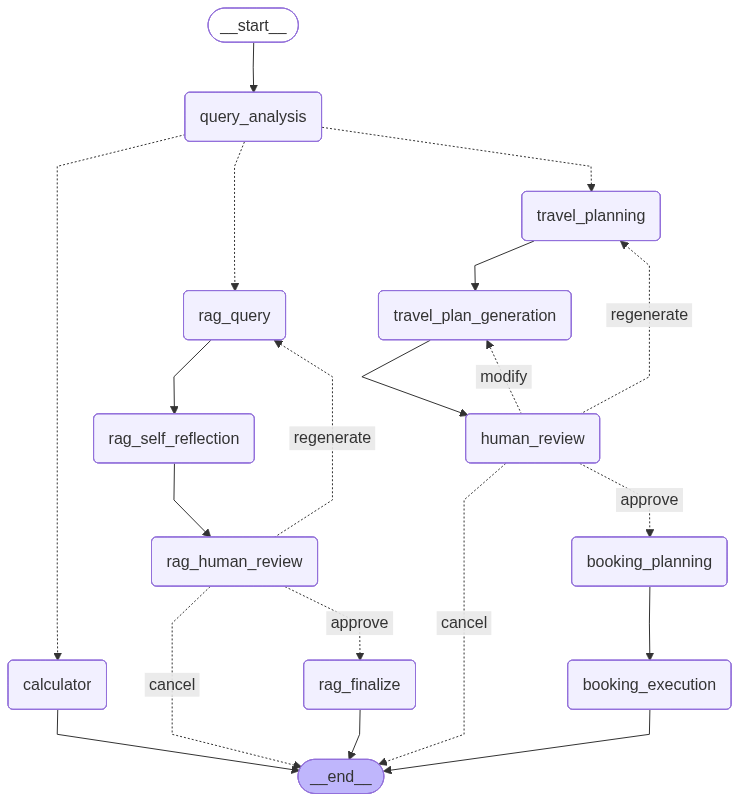

In [13]:

from IPython.display import Image, display

try:
    png = workflow.get_graph().draw_mermaid_png(
        max_retries=5,
        retry_delay=2.0,
    )
    display(Image(data=png))
except Exception as e:
    print(f"⚠️ Could not render graph visualization: {e}")

In [14]:
# Test the agent with a complex travel and booking query
result = workflow.invoke({
    "input": "Plan a 5 day Nashik trip and book flight and hotel",
    "steps": []
})

print("\nFINAL OUTPUT:\n", result["output"])
print("\nSTEPS:")
for s in result["steps"]:
    print("-", s)



🧑 HUMAN REVIEW

Here is a suggested itinerary for a 5-day trip to Nashik based on the provided plan:

**Day 1: Arrival in Nashik**

* Morning: Arrive at Nashik Airport (if booking flight) or take a train/ bus from nearby cities
* Afternoon: Check-in to hotel (booked in advance)
* Evening: Explore the city, visit the famous Panchavati area and try some local street food

**Day 2: Trimbakeshwar Temple and Vani**

* Morning: Visit the ancient Trimbakeshwar Temple (one of the 12 Jyotirlingas) located about 30 km from Nashik
* Afternoon: Head to Vani, a nearby town famous for its ancient temples and scenic views
* Evening: Return to Nashik and enjoy dinner at a local restaurant

**Day 3: Sula Vineyards and Igatpuri**

* Morning: Visit the Sula Vineyards, one of India's leading wine producers (optional wine tasting)
* Afternoon: Head to Igatpuri, a scenic hill station with breathtaking views of the Sahyadri mountains
* Evening: Return to Nashik and relax at the hotel

**Day 4: Nashik City T

In [15]:
# Test the agent with a RAG query
result = workflow.invoke({
    "input": "According to my documents, What is LangGraph?",
    "steps": []
})

print("\nFINAL OUTPUT:\n", result["output"])
print("\nSTEPS:")
for s in result["steps"]:
    print("-", s)



📚 RAG ANSWER
A framework for building stateful multi-agent workflows.

🧠 SELF-REFLECTION
PASS

Reason: The answer is grounded in the context of "documents" (presumably related to a project or research) and appears to be a technical description of LangGraph. There's no indication of missing information, and the response doesn't seem to introduce any unrelated or fictional concepts ("hallucination").

FINAL OUTPUT:
 A framework for building stateful multi-agent workflows.

STEPS:
- Router decided: rag_query
- RAG answer generated
- Self-reflection result: PASS

Reason: The answer is grounded in the context of "documents" (presumably related to a project or research) and appears to be a technical description of LangGraph. There's no indication of missing information, and the response doesn't seem to introduce any unrelated or fictional concepts ("hallucination").
- Human decision on RAG: approve
- RAG answer approved and finalized


In [16]:
# Test the agent with a calculator query
result = workflow.invoke({
    "input": "What is 2 + 2?",
    "steps": []
})

print("\nFINAL OUTPUT:\n", result["output"])
print("\nSTEPS:")
for s in result["steps"]:
    print("-", s)


FINAL OUTPUT:
 🧮 Result: 4

STEPS:
- Router decided: calculator
- Calculator executed: 2 + 2



FINAL OUTPUT:
 🧮 Result: 4

STEPS:
- Router decided: calculator
- Calculator executed: 2 + 2
